In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "careamics[examples]>=0.0.15",
# ]
# ///

The BSD68 dataset was adapted from K. Zhang et al (TIP, 2017) and is composed of natural
images. The noise was artificially added, allowing for quantitative comparisons with the
ground truth, one of the benchmark used in many denoising publications. Here, we check 
the performances of Noise2Void using the Lightning API of CAREamics.

This API gives you more freedom to customize the training by using wrappers around the
main elements of CAREamics: the datasets and the lightning module.

In [30]:
# Imports necessary to execute the code
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from PIL import Image
from careamics.lightning import (
    create_careamics_module,
    create_predict_datamodule,
    create_train_datamodule,
)
from careamics.config.support import SupportedTransform
from careamics.prediction_utils import convert_outputs
from careamics.utils.metrics import scale_invariant_psnr
from careamics_portfolio import PortfolioManager
from careamics.utils.lightning_utils import read_csv_logger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [12]:
use_gpu  = "yes" if len([torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]) > 0 else "no"
print(f"Using GPU: {use_gpu}")

Using GPU: yes


## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [13]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_BSD68.download(root_path)

# create paths for the data
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

## Visualize data

Text(0.5, 1.0, 'Validation Image')

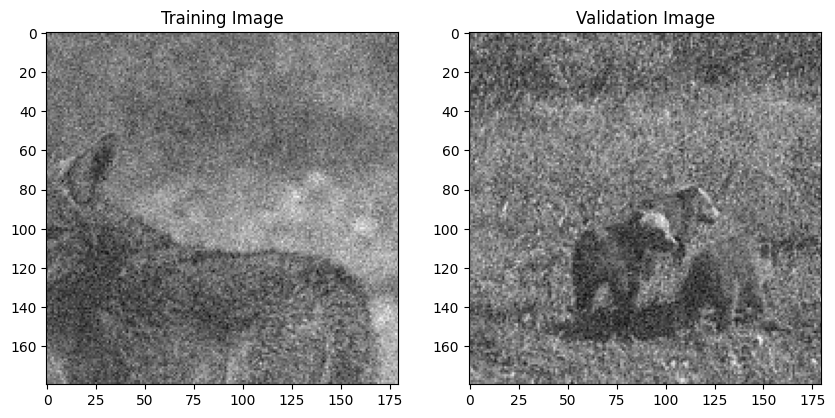

In [14]:
# load training and validation image and show them side by side
single_train_image = tifffile.imread(next(iter(train_path.rglob("*.tiff"))))[0]
single_val_image = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(single_train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(single_val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with the CAREamics Lightning API

Using the Lightning API of CAREamics, you need to instantiate the lightning module, the 
data module and the trainer yourself.

### Create the Lightning module

In [15]:
model = create_careamics_module(
    algorithm="n2v",
    loss="n2v",
    architecture="UNet",
    model_parameters={"n2v2": False},
)

### Create the data module

In [16]:
train_data_module = create_train_datamodule(
    train_data=train_path,
    val_data=val_path,
    data_type="tiff",
    patch_size=(64, 64),
    axes="SYX",
    batch_size=64,
    transforms=[
        { # you can delete a transform here to not apply it
            "name": SupportedTransform.XY_FLIP.value,
            "flip_x": True, # you can set parameters
            "flip_y": True,
        },
        {
            "name": SupportedTransform.XY_RANDOM_ROTATE90.value,
        },
    ],
)

### Create the trainer

Note that here we modify the prediction loop, but this will be  changed in the near
future.

In [17]:
# Create Callbacks
root = Path("bsd68_n2v")
callbacks = [
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="bsd68_lightning_api",
        save_last=True,
    )
]

# Create a Lightning Trainer
trainer = Trainer(max_epochs=100, default_root_dir=root, callbacks=callbacks)

# Train the model
trainer.fit(model, datamodule=train_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Extracted 28512 patches from input array.
Computed dataset mean: [110.75299], std: [63.603928]
Extracted 36 patches from input array.
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-dwcy-pak-b206306a8ac76b72/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /localscratch/careamics-examples/applications/lightning_api/2D/bsd68_n2v/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 333 K  | train
---------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.335     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Plot losses.

## Predict with CAREamics Lightning API

### Define the prediction datamodule

In [26]:
means, stds = train_data_module.get_data_statistics()
pred_data_module = create_predict_datamodule(
    pred_data=test_path,
    data_type="tiff",
    axes="YX",
    batch_size=1,
    tta_transforms=True,
    image_means=means,
    image_stds=stds,
    tile_size=(128, 128),
    tile_overlap=(32, 32),
)

### Predict

In [27]:
# Predict
prediction = trainer.predict(model, datamodule=pred_data_module)

# Convert the outputs to the original format, mostly useful if tiling is used
prediction = convert_outputs(prediction, tiled=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joran.deschamps/.cache/uv/environments-v2/juv-tmp-dwcy-pak-b206306a8ac76b72/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualize the prediction

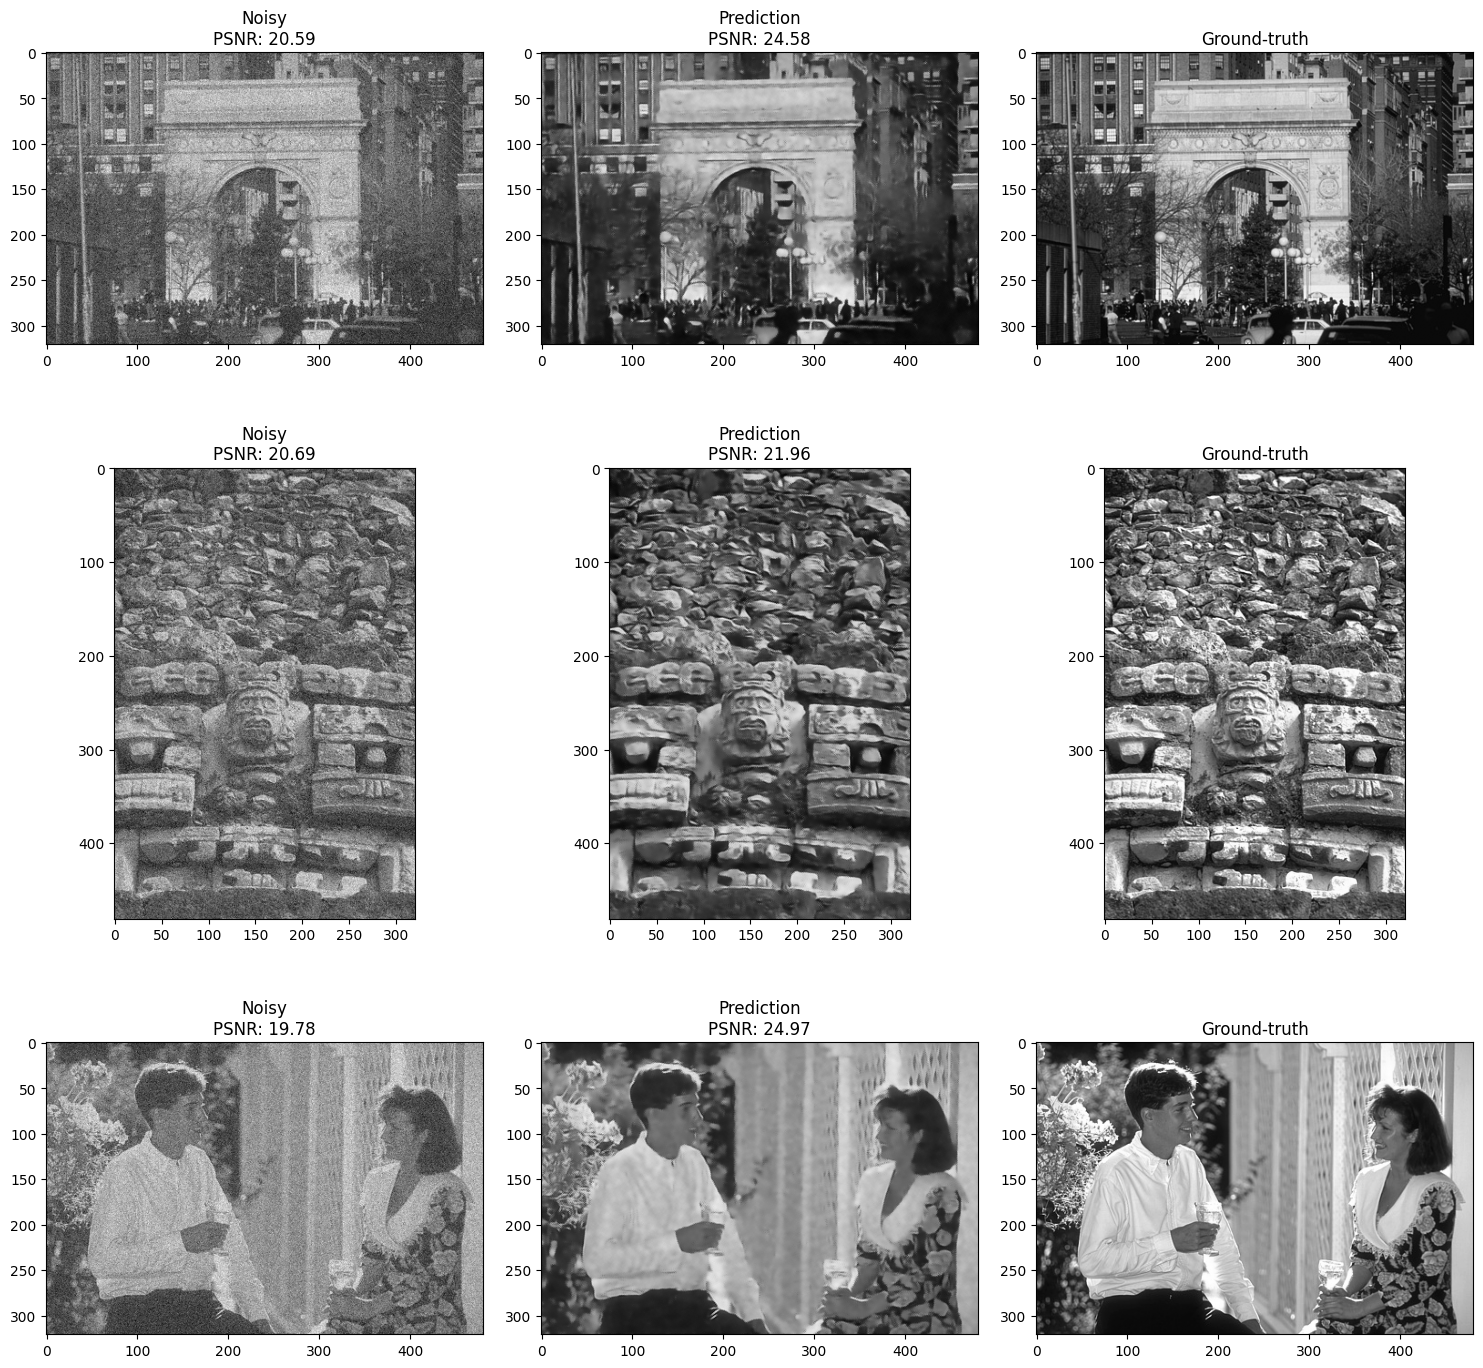

In [31]:
# Show two images
noises = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

# images to show
images = np.random.choice(range(len(noises)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = prediction[images[i]].squeeze()
    psnr_noisy = scale_invariant_psnr(gts[images[i]], noises[images[i]])
    psnr_result = scale_invariant_psnr(gts[images[i]], pred_image)

    ax[i, 0].imshow(noises[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}")

    ax[i, 2].imshow(gts[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")

### Compute metrics

In [33]:
psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(prediction, gts)):
    psnrs[i] = scale_invariant_psnr(gt, pred.squeeze())

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")
print("Reported PSNR: 27.71")

PSNR: 26.30 +/- 2.64
Reported PSNR: 27.71


## Create cover

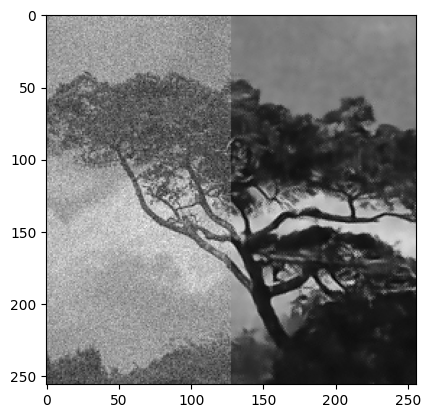

In [34]:
# create a cover image
im_idx = 3
cv_image_noisy = noises[im_idx]
cv_image_pred = prediction[im_idx].squeeze()

# create image
cover = np.zeros((256, 256))   
(height, width) = cv_image_noisy.shape
assert height > 256
assert width > 256

# normalize train and prediction
norm_noise = (cv_image_noisy - cv_image_noisy.min()) / (cv_image_noisy.max() - cv_image_noisy.min())
norm_pred = (cv_image_pred - cv_image_pred.min()) / (cv_image_pred.max() - cv_image_pred.min())

# fill in halves
cover[:, :256 // 2] = norm_noise[height // 2 - 256 // 2:height // 2 + 256 // 2, width // 2 - 256 // 2:width // 2]
cover[:, 256 // 2:] = norm_pred[height // 2 - 256 // 2:height // 2 + 256 // 2, width // 2:width // 2 + 256 // 2]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert('L')
im.save("BSD68_Noise2Void_lightning_api.jpeg")